# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Measuring the Shape and Brightness of Galaxies with Neural Networks


**Harvard University**<br/>
**CS109b Spring 2020, Final Project F**<br/>
**Group 30**: Ziwei Qiu, Hayden Joy, Zachary Murray, and Daniel Cox


<hr style="height:2pt">

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Table of Contents
(click on link to go to section indicated)

  
* [CNN model predicting five parameters at once](#CNN-model-predicting-five-parameters-at-once)
    * [Model architecture and fitting](#Model-architecture-and-fitting)
    * [Predicting each parameter](#Predicting-each-parameter)
    * [Estimating uncertainties and comparing to the Cramer-Rao bound](#Estimating-uncertainties-and-comparing-to-the-Cramer-Rao-bound)
    * [Saving the uncertainty estimates](#Saving-the-uncertainty-estimates)
   
    
* [Conclusions](#Conclusions)





### Import libraries

In [1]:
import sys
import math
import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

###  Importing data, making train and test datasets

**The 'label' in the data set is a concatenate of physical parameters (flux, sersic index, sersic radius, g1, g2). g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. g1= (1-q)/(1+q) cos phi and g2= (1-q)/(1+q) sin phi, where q is ellipticity and phi is orientation. ***

Here is literature: http://2017.ds3-datascience-polytechnique.fr/wp-content/uploads/2017/08/DS3_posterID_012.pdf

In [2]:
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('Data1.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)
split = int(0.8*total_num)

total number of images: 18779


In [3]:
np.random.seed(100)
ind = np.arange(total_num)
np.random.shuffle(ind)
train_ind = ind[0:split]
train_ind = np.sort(train_ind)
test_ind = ind[split:]
test_ind = np.sort(test_ind)

# train dataset
image_tr = f['img'][train_ind]
cat_tr = f['cat'][train_ind]  
label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
snr_tr = f['snr'][train_ind]
sigma_tr = f['sigma'][train_ind]
image_nonoise_tr = f['img_nonoise'][train_ind]    
image_withnoise_tr = f['img_withnoise'][train_ind]
print('training set done.')

# test dataset
image_te = f['img'][test_ind]
cat_te = f['cat'][test_ind]  
label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
snr_te = f['snr'][test_ind]
sigma_te = f['sigma'][test_ind]
image_nonoise_te = f['img_nonoise'][test_ind]    
image_withnoise_te = f['img_withnoise'][test_ind]   
print('test set done.')

training set done.
test set done.


In [4]:
# Reshape such that the images are ready for training
image_tr = image_tr.reshape(image_tr.shape[0],64,64,1)
image_te = image_te.reshape(image_te.shape[0],64,64,1)

image_nonoise_tr = image_nonoise_tr.reshape(image_nonoise_tr.shape[0],64,64,1)
image_nonoise_te = image_nonoise_te.reshape(image_nonoise_te.shape[0],64,64,1)

image_withnoise_tr = image_withnoise_tr.reshape(image_withnoise_tr.shape[0],64,64,1)
image_withnoise_te = image_withnoise_te.reshape(image_withnoise_te.shape[0],64,64,1)

In [10]:
# An example from the training set
fig= plt.figure(figsize=(3,3))
plt.imshow(image_withnoise_tr[1,:,:,0])
plt.colorbar()
plt.show()

In [6]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

## CNN model predicting five parameters at once

### Model architecture and fitting
This CNN model has a descending number of filters and outputs 5 parameters at once.

In [14]:
cnnmodel = models.Sequential()
#cnnmodel.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(5, activation='linear'))
cnnmodel.summary()

In [57]:
cnnmodel = models.load_model('cnnmodel2.h5')

In [58]:
cnnmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        65600     
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)       

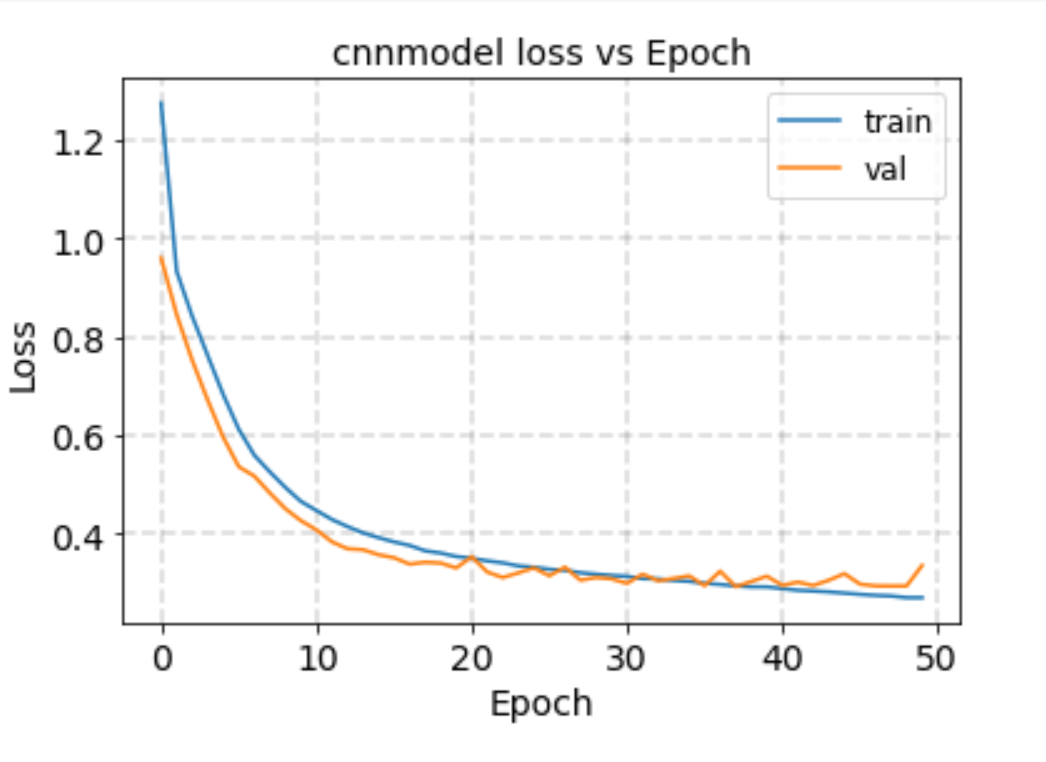

In [21]:
from IPython.display import Image
Image(filename = 'loss2.png', width=500, height=5)

In [59]:
val_loss = cnnmodel.evaluate(image_withnoise_te, label_te_scaled,verbose = 0)
print('The validation loss MSE is {:0.6f}.'.format(val_loss))

The validation loss MSE is 0.344965.


### Predicting each parameter

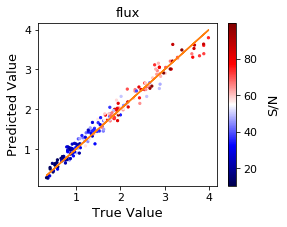

In [60]:
plot_prediction2(cnnmodel, 0)

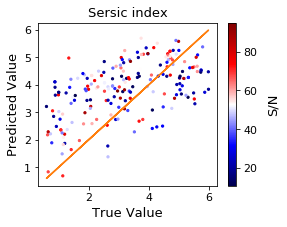

In [61]:
plot_prediction2(cnnmodel, 1)

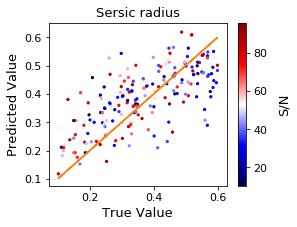

In [62]:
plot_prediction2(cnnmodel, 2)

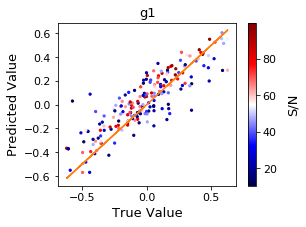

In [63]:
plot_prediction2(cnnmodel, 3)

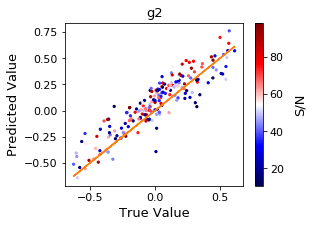

In [64]:
plot_prediction2(cnnmodel, 4)

### Estimating uncertainties and comparing to the Cramer-Rau bound

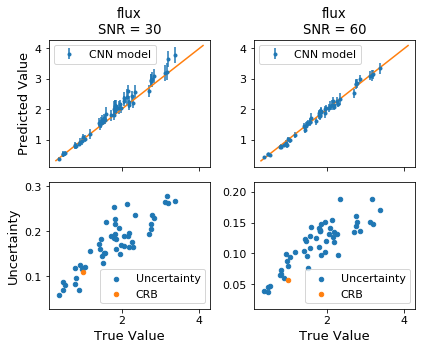

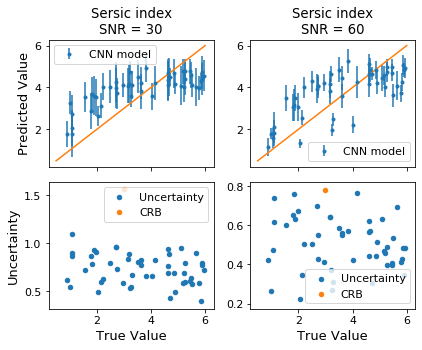

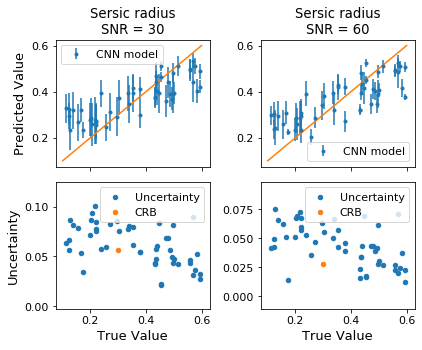

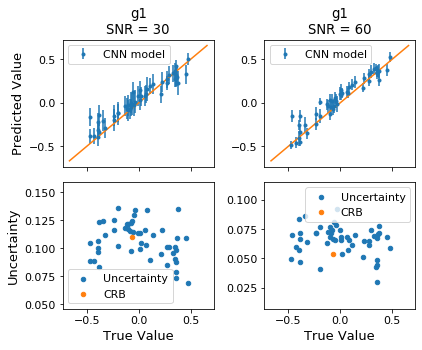

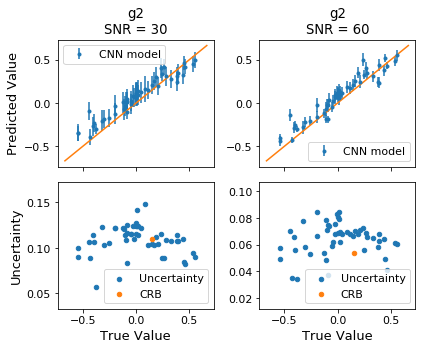

In [65]:
true_values_cnn2, mean_cnn2, sigma_cnn2 = plot_uncertainty2(cnnmodel,snr=[30,60], 
                                                            num_of_pts=num_of_pts, sampling_size = 100)

### Saving the uncertainty estimates

In [12]:
#Save the results
np.save('true_values_cnn2.npy', true_values_cnn2)
np.save('mean_cnn2.npy', mean_cnn2)
np.save('err_cnn2.npy', sigma_cnn2)